In [110]:
import torch
from transformers import GenerationConfig

from datetime import datetime
import json
import numpy as np
import math
import tqdm

from T2CEvaluator import T2CEvaluator

from prompter import Prompter
prompter = Prompter()

def generate_test_prompt(data_point):
    #assert 'output' not in data_point or data_point['output']==''
    if "input" in data_point and data_point["input"]:
        return prompter.generate_prompt(instruction = data_point["instruction"],
                                        input = data_point["input"],
                                        #label = ''#data_point["output"]
                                       )
    else:
        return prompter.generate_prompt(instruction = data_point["instruction"],
                                        #input = None,
                                        #label = ''#data_point["output"]
                                       )
   
# def generate_test_prompt(data_point, train = False):
#     # To decrease expectations of results :)
#     assert train == False
#     # sorry about the formatting disaster gotta move fast
#     if data_point["input"]:
#         return f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.
# ### Instruction:
# {data_point["instruction"]}

# ### Input:
# {data_point["input"]}

# ### Response:
# {data_point["output"] if train else ''}"""
#     else:
#         return f"""Below is an instruction that describes a task. Write a response that appropriately completes the request.
# ### Instruction:
# {data_point["instruction"]}

# ### Response:
# {data_point["output"] if train else ''}"""


class EvaluateTestSet:
    def __init__(self, 
                 generation_config = GenerationConfig(max_new_tokens = 128), 
                 fn_test_data = "../data/t2c_answers.json",
                 fn_etalon = "/root/data/answers.json",
                 batch_size = 10,
                 verbose = False
                ):
        self.generation_config = generation_config
        
        self.fn_test_data = fn_test_data
        self.fn_etalon = fn_etalon
        
        self.batch_size = batch_size
        self.verbose = verbose
       
    def preprocess(self, s):
        #ToDo rewrite it using Promt Template
        print("===\n" + s + "\n===")
        s = prompter.get_response(s)#.split("###")[0]
        #s = s.split('### Response:\n')[-1]#.split("### Input")[0]
        s = s.replace('\n', '  ')
        s = s.replace('<unk>', " ")
        #s = ' '.join(s.split(' ')[:100])
        while '  ' in s:
            s = s.replace('  ', ' ')

        if len(s) > 0 and s[0] == ' ':
            s = s[1:]
        
        if self.verbose:
            print(s)
        
        return s

    def clean_results(self, res_list):
        predict_list = []
        for s in tqdm.tqdm(res_list):
            predict_list.append(self.preprocess(s))
        return predict_list
    
    def get_raw_results(self, model, tokenizer, prompts):
        batch_size = self.batch_size
        generation_config = self.generation_config
        
        res_list = []
        n = math.ceil(len(prompts)/batch_size)
        
        for ind in tqdm.tqdm(range(n)):
            current_prompts = prompts[ind*batch_size: (ind+1)*batch_size]
            if self.verbose:
                print(ind * batch_size, (ind+1)*batch_size, len(current_prompts))

            tokenized_inputs = tokenizer(list(current_prompts), 
                                         padding=True, 
                                         truncation=True, 
                                         return_tensors="pt"
                                        ).to('cuda')



            with torch.no_grad():
                full_output = model.generate(
                    **tokenized_inputs,
                    generation_config=generation_config
                )

            res_list.extend(tokenizer.batch_decode(full_output, skip_special_tokens=False))
        
        return res_list
    
    def save_results(self, predict_list):
        output_filename = str(datetime.now()).split('.')[0].replace(' ', '-').replace(':', '_')+'.txt'
        fn_output = "/root/results/%s"%output_filename
        
        res = '\n'.join([i if i!='' else '-' for i in predict_list])
        open(fn_output, "w+", encoding='utf-8').write(res)
        return fn_output
    
    def evaluate(self, model, tokenizer):
        model.eval()
        assert model.training == False

        lst = json.load(open(self.fn_test_data, 'rb'))
        inputs = lst# [lst[0]]
        # instruction = 'Combine the question and answer into an image caption as succinctly as possible. Be sure to include the phrase "a photo of". Do not draw false conclusions.'
        # inputs = ['Is this a baseball game? yes', 'Is this a baseball game? no']
        #print(inputs)
        prompts = [generate_test_prompt(inp) for inp in inputs]
        prompts = np.array(prompts)
        
        res_list = self.get_raw_results(model = model, 
                                        tokenizer = tokenizer,
                                        prompts = prompts)
        
        model.train()
        assert model.training == True
        
        predict_list = self.clean_results(res_list)
        
        self.fn_output = self.save_results(predict_list)
        
        t2c_evaluator = T2CEvaluator()
        metric_res = t2c_evaluator.calculate_metrics(fn_answers = self.fn_etalon, 
                                                     fn_predictions = self.fn_output
                                                     )
        return metric_res

/root/git/experiments_ipynb/prompter/templates/


In [ ]:
model.generate()

In [2]:
!ls /root/experiments/

t2c_concode_220428_v12	t2c_concode_220428_v18	t2c_concode_220428_v31
t2c_concode_220428_v13	t2c_concode_220428_v19	t2c_concode_220428_v32
t2c_concode_220428_v14	t2c_concode_220428_v20	t2c_concode_220428_v9
t2c_concode_220428_v15	t2c_concode_220428_v22
t2c_concode_220428_v16	t2c_concode_220428_v30


In [3]:
from utils import load_model_tokenizer_from_pretrained
import pandas as pd
from transformers import GenerationConfig
from tqdm import tqdm_notebook

default_model = "decapoda-research/llama-7b-hf"
experiment_name = "/root/experiments/t2c_concode_220428_v19/"

/root/git/experiments_ipynb/prompter/templates/

===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching /usr/local/cuda/lib64...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 117
CUDA SETUP: Loading binary /opt/conda/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda117.so...


/opt/conda/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('module'), PosixPath('//matplotlib_inline.backend_inline')}
  warn(msg)


In [4]:
tokenizer, model = load_model_tokenizer_from_pretrained(default_model = default_model, 
                                                        experiment_name = experiment_name
                                                       )

Overriding torch_dtype=None with `torch_dtype=torch.float16` due to requirements of `bitsandbytes` to enable model loading in mixed int8. Either pass torch_dtype=torch.float16 or don't pass this argument at all to remove this warning.


Loading checkpoint shards:   0%|          | 0/33 [00:00<?, ?it/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LLaMATokenizer'. 
The class this function is called from is 'LlamaTokenizer'.


In [21]:
import json

# fn_answers = "/root/data/answers.json"
fn_test_data = "/root/data/t2c_answers.json"
# X = [json.loads(i) for i in open(fn_test_data, "r").\
#                                               read().\
#                                               split('\n')
#                 if i!=''
#                ]
X = json.load(open(fn_test_data, 'r'))


In [224]:
current_prompts = [generate_test_prompt(i) for i in X[:1]]
# print(current_prompts[2])

tokenized_inputs = tokenizer(list(current_prompts), 
                             padding=True, 
                             truncation=True, 
                             return_tensors="pt"
                            ).to('cuda')



with torch.no_grad():
    full_output = model.generate(
        **tokenized_inputs,
        generation_config=GenerationConfig(max_new_tokens = 200)
    )

res_list = tokenizer.batch_decode(full_output, skip_special_tokens=False)

In [223]:
full_output_old = full_output.cpu().numpy()

In [236]:
# print(tokenizer.decode(full_output[0]))
s1 = tokenizer.decode(full_output[0])[:1200]
s2 = tokenizer.decode(full_output_old[0]).split('<unk>')[-1][:1200]

In [249]:
l = 900
r = 950
print(s1[l:r] == s2[l:r])
print("[1]: ", s1[l:r])
print("[2]: ", s2[l:r])

False
[1]:  void function ( ) { _total = 0 ; }

### Input:
 Ma
[2]:  void function ( ) { _total = 0 ; }

### Input:
 Ob


In [255]:
# print(s1[900:])

In [256]:
# print(s2[900:])

<s>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Generate java code
actually walks the bag to make sure the count is correct and resets the running total 

### Input:
 Object _current 
 int _total 
 DefaultMapBag _parent 
 Map _map 
 int _mods 
 Iterator _support 

 boolean add 
 boolean add 
 Object next 
 boolean containsAll 
 boolean containsAll 
 void clear 
 boolean isEmpty 
 boolean hasNext 
 void remove 
 boolean remove 
 boolean remove 
 Map getMap 
 int modCount 
 boolean contains 
 Iterator iterator 
 boolean removeAll 
 int size 
 boolean addAll 
 int hashCode 
 boolean equals 
 Object[] toArray 
 Object[] toArray 
 Set uniqueSet 
 void setMap 
 String toString 
 int getCount 
 List extractList 
 boolean retainAll 
 boolean retainAll

### Response:
void function ( ) { _total = 0 ; }

### Input:
 MapBag _parent 
 Map _map 
 int _mods 
 int _total 


In [216]:
# tokenizer.decode(lst1[:47])

In [217]:
# tokenizer.decode(lst2[:47])

In [175]:
# print(current_prompts[0])
# tokenized_inputs['input_ids'][2]
lst = full_output[2][:424]
print(lst)
print(tokenizer.decode(lst))

tensor([    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     1, 13866,
          338,   385, 15278,   393, 16612,   263,  3414, 29892,  3300,  2859,
          411,   385,  1881,   393,  8128,  4340,  3030, 29889, 14350,   263,
         2933,   393,  7128,  2486,  1614,  2167,   278,  2009, 

tensor([    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [140]:
print(res_list[0])

<unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><s>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Genera

In [95]:
from transformers import LlamaTokenizer as LLaMATokenizer
tokenizer = LLaMATokenizer.from_pretrained(default_model)
model.config.pad_token_id = tokenizer.pad_token_id = 0  # unk
tokenizer.padding_side = "left"
# not sure how necessary this part is, not sure if tloen/alpaca-lora-7b was even trained with EOS and BOS tokens
model.config.bos_token_id = 1
model.config.eos_token_id = 2


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LLaMATokenizer'. 
The class this function is called from is 'LlamaTokenizer'.


In [137]:
tokenizer.pad_token_id# = 0  # unk. we want this to be different from the eos token

0

In [119]:
tokenizer.pad_token_id = 0
tokenizer.eos_token_id = 2

In [125]:
model.config.bos_token_id, tokenizer.bos_token_id

(1, 0)

In [122]:
assert tokenizer.pad_token_id == model.config.pad_token_id
assert tokenizer.eos_token_id == model.config.eos_token_id
assert c == model.config.bos_token_id

AssertionError: 

In [132]:
tokenizer.unk_token_id = None


In [134]:
tokenizer.bos_token_id = 1

In [135]:
for s in ['bos_token_id', 'eos_token_id', 'unk_token_id',
          'sep_token_id', 'pad_token_id', 'cls_token_id']:
    print(f"tokenizer.{s}", getattr(tokenizer, s))
    print(f"model.config.{s}", getattr(model.config, s) if hasattr(model.config, s) else None)

tokenizer.bos_token_id 1
model.config.bos_token_id 1
tokenizer.eos_token_id 2
model.config.eos_token_id 2
tokenizer.unk_token_id None
model.config.unk_token_id None
tokenizer.sep_token_id None
model.config.sep_token_id None
tokenizer.pad_token_id 0
model.config.pad_token_id 0
tokenizer.cls_token_id None
model.config.cls_token_id None


In [128]:
[i for i in tokenizer.__dir__() if 'token_id' in i]

['bos_token_id',
 'eos_token_id',
 'unk_token_id',
 'sep_token_id',
 'pad_token_id',
 'cls_token_id',
 'mask_token_id']

In [126]:
print("tokenizer.pad_token_id", tokenizer.pad_token_id)
print("tokenizer.eos_token_id", tokenizer.eos_token_id)
print("tokenizer.bos_token_id", tokenizer.bos_token_id)
print("tokenizer.eos_token_id", tokenizer.eos_token_id)

print("model.config.pad_token_id", model.config.pad_token_id)
print("model.config.eos_token_id", model.config.eos_token_id)
print("model.config.bos_token_id", model.config.bos_token_id)
print("model.config.eos_token_id", model.config.eos_token_id)

tokenizer.pad_token_id 0
tokenizer.eos_token_id 2
model.config.pad_token_id 0
model.config.eos_token_id 2


In [91]:
# current_prompts = [generate_test_prompt(i) for i in X[:3]]
# print(current_prompts[2])

In [90]:
# tokenizer.vocab_file

In [89]:
# from transformers import LlamaTokenizer as LLaMATokenizer
# tokenizer = LLaMATokenizer.from_pretrained(default_model)

In [88]:
# tokenizer._pad_token

In [92]:
# !tail /root/.cache/huggingface/hub/models--decapoda-research--llama-7b-hf/snapshots/5f98eefcc80e437ef68d457ad7bf167c2c6a1348/tokenizer.model

In [94]:
# tokenizer.add_special_tokens({'pad_token': '[PAD]'})

In [93]:
# tokenizer("[PAD]")
# tokenizer.i

In [71]:
tokenized_inputs = tokenizer(list(current_prompts), 
                             padding=True, 
                             truncation=True, 
                             return_tensors="pt"
                            ).to('cuda')



In [72]:
# tokenizer.pad_token = '<unk>'

In [73]:
# tokenizer("<s>")

In [68]:
tokenizer.decode([529])

'<'

In [76]:
# print(tokenizer.decode(tokenized_inputs['input_ids'][0]))

In [17]:
# generate_test_prompt(X[0])
# !head /root/data/t2c_answers.json
# !head temp/answers.json

In [114]:
tokenizer.pad_token_id,\
model.config.pad_token_id

(1, 0)

In [106]:
!ls /root/ipynb/temp

answers.json  t2c_answers.json


In [136]:
evaluator = EvaluateTestSet(generation_config = GenerationConfig(max_new_tokens = 200
                                                                ),
                            fn_test_data = "/root/ipynb/temp/t2c_answers.json",
                            fn_etalon = "/root/ipynb/temp/answers.json",
                            batch_size = 10
                           )

metric_res = evaluator.evaluate(model=model, 
                                tokenizer=tokenizer,
                               )
# for key, val in generation_config_dict.items():
#     assert key not in metric_res
#     metric_res[key] = val

metric_res['experiment_name'] = experiment_name
metric_res

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 80350.65it/s]

===
<unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><s>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Ge

{'EM': 0.0,
 'BLEU': 0.11543722726688209,
 'brevity_penalty': 1.0,
 'ratio': 2.6805385556915544,
 'translation_length': 2190,
 'reference_length': 817,
 'precisions_0': 0.22774988589685075,
 'precisions_1': 0.14021286441462286,
 'precisions_2': 0.09056780854059127,
 'precisions_3': 0.061399333650642554,
 'experiment_name': '/root/experiments/t2c_concode_220428_v19/'}

In [6]:
# res = {}
# path = '/root/results/'

# for filename in os.listdir(path):
# #     print(filename)
# #     if filename < "2023-05-09-22_22_44.txt":
# #         continue
#     try:
#         fn = os.path.join(path, filename)
#         t2c_evaluator = T2CEvaluator()

#         txt = '\n'.join([i.split('### Input')[0] 
#                          for i in open(fn,
#                                        "r"
#                                       ).read().split('\n')]
#                        )

#         open("test_test_res.txt", "w+").write(txt)
#         metric_res = t2c_evaluator.calculate_metrics(fn_answers = "/root/data/answers.json", 
#                                                      fn_predictions = "test_test_res.txt"
#                                                      )

#         res[filename] = metric_res
# #         print("OK")
#     except:
#         pass
# #         print("FAIL")
# res = pd.DataFrame(res).T
# res.sort_values("BLEU", ascending = False)

In [26]:
pd.DataFrame(res).T.sort_values("BLEU", ascending = False)[:40]

,EM,BLEU,brevity_penalty,ratio,translation_length,reference_length,precisions_0,precisions_1,precisions_2,precisions_3
2023-05-06-09_09_12.txt,6.0,0.326877,1.000000,1.007079,3130.0,3108.0,0.531779,0.382382,0.274991,0.204168
2023-05-12-10_14_59.txt,13.0,0.326089,0.986721,0.986808,3067.0,3108.0,0.547914,0.388814,0.278243,0.201228
2023-05-06-09_18_46.txt,6.0,0.324502,0.949203,0.950450,2954.0,3108.0,0.553299,0.399299,0.287477,0.215066
2023-05-06-09_17_21.txt,6.0,0.321185,0.924232,0.926963,2881.0,3108.0,0.561069,0.405464,0.291946,0.219597
2023-05-06-09_15_58.txt,6.0,0.317833,0.897963,0.902831,2806.0,3108.0,0.569291,0.412634,0.298044,0.224172
2023-05-12-10_13_06.txt,13.0,0.316682,0.892277,0.897683,2790.0,3108.0,0.581154,0.414344,0.299769,0.219815
2023-05-06-09_05_48.txt,6.0,0.315559,0.884053,0.890283,2767.0,3108.0,0.574061,0.416042,0.300623,0.226094
2023-05-12-10_30_23.txt,13.0,0.313379,0.847223,0.857786,2666.0,3108.0,0.605174,0.432801,0.312120,0.228982
2023-05-06-09_14_39.txt,6.0,0.313104,0.869970,0.877735,2728.0,3108.0,0.579700,0.419171,0.303282,0.227666
2023-05-10-22_18_28.txt,17.0,0.311010,0.677911,0.720077,2238.0,3108.0,0.705672,0.533427,0.394801,0.298092


In [8]:
# !ls -lah /root/results/

In [8]:
model.eval();

In [9]:
from tqdm import tqdm_notebook
from ParamsIterator import ParamsIterator

res = []
def get_metric_res(model, tokenizer, params_iteration, experiment_name, batch_size = 10):
    global res
    res = []
    for generation_config_dict in tqdm_notebook(ParamsIterator(params_iteration=params_iteration)):
        evaluator = EvaluateTestSet(generation_config = GenerationConfig(**generation_config_dict
                                                                        ),
                                    #fn_test_data = "temp/t2c_answers.json",
                                    #fn_etalon = "temp/answers.json"
                                    batch_size = batch_size
                                   )

        metric_res = evaluator.evaluate(model=model, 
                                        tokenizer=tokenizer,
                                       )
        for key, val in generation_config_dict.items():
            assert key not in metric_res
            metric_res[key] = val

        metric_res['experiment_name'] = experiment_name
        print(generation_config_dict, metric_res)

        res.append(metric_res)
    
    return res

In [118]:
params_iteration = {"temperature": [1.0],
#                     "top_k":
                    "max_new_tokens": [200]# + list(range(100))
                   }

In [119]:
res_fin3 = get_metric_res(model=model,
                     tokenizer=tokenizer,
                     params_iteration=params_iteration,
                     experiment_name=experiment_name,
                     batch_size = 10
                    )

/tmp/ipykernel_19479/1533748013.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for generation_config_dict in tqdm_notebook(ParamsIterator(params_iteration=params_iteration)):


  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [05:03<00:00, 30.37s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 208568.08it/s]

{'max_new_tokens': 200, 'temperature': 1.0} {'EM': 20.0, 'BLEU': 0.33418182083411807, 'brevity_penalty': 0.9682981713393486, 'ratio': 0.9687902187902188, 'translation_length': 3011, 'reference_length': 3108, 'precisions_0': 0.5438247011952191, 'precisions_1': 0.4024725274725275, 'precisions_2': 0.29445234708392604, 'precisions_3': 0.22013274336283187, 'max_new_tokens': 200, 'temperature': 1.0, 'experiment_name': '/root/experiments/t2c_concode_220428_v19/'}


In [104]:
len(res_fin), len(res_fin2)

(6, 5)

In [96]:
df2 = pd.read_csv("/root/experiments/t2c_concode_220428_v19/metrics.csv")
df2 = df2.sort_values('max_new_tokens')

In [120]:
df1 = pd.DataFrame(res_fin + res_fin2 + res_fin3)

In [110]:
res2 = res_fin + res_fin2

11

In [116]:
# df1 = pd.DataFrame(res_fin + res_fin2)

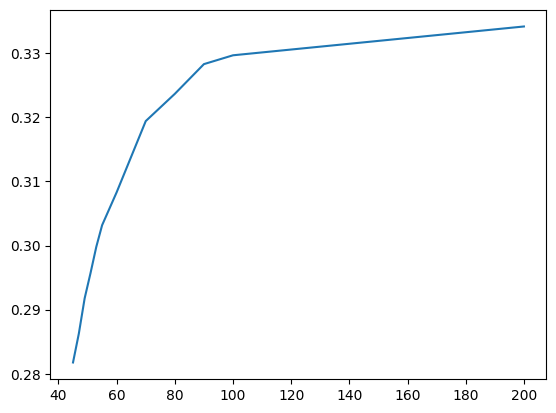

In [123]:
from matplotlib import pyplot as plt
%matplotlib inline

# df1 = pd.DataFrame(res_fin)
plt.plot(df1['max_new_tokens'], df1['BLEU'])
# plt.plot(df2['max_new_tokens'], df2['BLEU'])

In [124]:
df1.to_csv("df1_temp1.csv")

In [91]:
df1['brevity_penalty']

0    0.568834
1    0.584001
2    0.598610
3    0.612230
4    0.625313
5    0.638297
Name: brevity_penalty, dtype: float64

In [ ]:
evaluator = EvaluateTestSet(generation_config = GenerationConfig(max_new_tokens = 49
                                                                ),
                            #fn_test_data = "temp/t2c_answers.json",
                            #fn_etalon = "temp/answers.json"
                            batch_size = 10
                           )

metric_res = evaluator.evaluate(model=model, 
                                tokenizer=tokenizer,
                               )
# for key, val in generation_config_dict.items():
#     assert key not in metric_res
#     metric_res[key] = val

metric_res['experiment_name'] = experiment_name
metric_res

In [ ]:
# max_length = 1024

# max_length = 400, 
# {'EM': 0.0,
#  'BLEU': 0.20770774117978485,
#  'brevity_penalty': 0.7887852726079982,
#  'ratio': 0.8082368082368082,
#  'translation_length': 2512,
#  'reference_length': 3108,
#  'precisions_0': 0.4341424592120971,
#  'precisions_1': 0.3033568172399503,
#  'precisions_2': 0.2197195070123247,
#  'precisions_3': 0.1661578717836895,
#  'experiment_name': '/root/experiments/t2c_concode_220428_v19/'
# }

# max_length = 256, BLEU =  7.106139847448361e-12


# title = "best result ever", max_length = 512
# {'EM': 0.0,
#  'BLEU': 0.19442009681675598,
#  'brevity_penalty': 1.0,
#  'ratio': 1.4996782496782497,
#  'translation_length': 4661,
#  'reference_length': 3108,
#  'precisions_0': 0.3344058344058344,
#  'precisions_1': 0.22709338009644892,
#  'precisions_2': 0.1598479767493852,
#  'precisions_3': 0.1177007299270073,
#  'max_length': 512,
#  'experiment_name': '/root/experiments/t2c_concode_220428_v19/'}

# title = "best result ever", max_length = 512
# {'EM': 0.0,
#  'BLEU': 0.3069243409072005,
#  'brevity_penalty': 0.8743219831966469,
#  'ratio': 0.8815958815958816,
#  'translation_length': 2740,
#  'reference_length': 3108,
#  'precisions_0': 0.5618387449835827,
#  'precisions_1': 0.40931465354032565,
#  'precisions_2': 0.2975206611570248,
#  'precisions_3': 0.22194922194922195,
#  'max_new_tokens': 49,
#  'experiment_name': '/root/experiments/t2c_concode_220428_v19/'
# }


# title = "best result ever", batch_size = 20
# {'EM': 0.0,
#  'BLEU': 0.3069243409072005,
#  'brevity_penalty': 0.8743219831966469,
#  'ratio': 0.8815958815958816,
#  'translation_length': 2740,
#  'reference_length': 3108,
#  'precisions_0': 0.5618387449835827,
#  'precisions_1': 0.40931465354032565,
#  'precisions_2': 0.2975206611570248,
#  'precisions_3': 0.22194922194922195,
#  'max_new_tokens': 49,
#  'experiment_name': '/root/experiments/t2c_concode_220428_v19/'
# }

# title = "best result ever", batch_size = 5
# {'EM': 0.0,
#  'BLEU': 0.3094605290687326,
#  'brevity_penalty': 0.8757688775902636,
#  'ratio': 0.8828828828828829,
#  'translation_length': 2744,
#  'reference_length': 3108,
#  'precisions_0': 0.5632058287795992,
#  'precisions_1': 0.4109640831758034,
#  'precisions_2': 0.29901768172888016,
#  'precisions_3': 0.22526573998364677,
#  'max_new_tokens': 49,
#  'experiment_name': '/root/experiments/t2c_concode_220428_v19/'
# }

# title = ("best result ever"|"t2c_concode_220428_v19"), batch_size = {None|10}
# {'EM': 0.0,
#  'BLEU': 0.31417807176317536,
#  'brevity_penalty': 0.8993798379997678,
#  'ratio': 0.9041184041184042,
#  'translation_length': 2810,
#  'reference_length': 3108,
#  'precisions_0': 0.5592315901814301,
#  'precisions_1': 0.40575433419402435,
#  'precisions_2': 0.2949061662198391,
#  'precisions_3': 0.22253184713375795,
#  'max_new_tokens': 49,
#  'experiment_name': '/root/experiments/t2c_concode_220428_v19/'}